In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import AutoModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
import torch
from spacy.lang.en import English
dvu.set_style()
import sys
sys.path.append('..')
import pandas as pd
from functools import partial
from embgam import analyze_helper
from embgam import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import embgam

# Calculate interpolation stuff

In [2]:
dsets = ['financial_phrasebank', 'rotten_tomatoes', 'sst2', 'emotion']
out = defaultdict(list)
for dset in tqdm(dsets):
    # get data
    dataset, dataset_key_text = embgam.data.process_data_and_args(dset)
    dval = dataset['validation']

    # load embgam model #####################################################
    embgam_checkpoints = {
        # 'tweet_eval': 'results/best___ngram=2_sub=-1_philschmid-BERT-tweet-eval-emotion__last_hidden_state_mean__1-all.pkl',
        'rotten_tomatoes': 'results/best___ngram=5_sub=-1_textattack-bert-base-uncased-rotten_tomatoes__2-all.pkl',
        'emotion': 'results/best___ngram=6_sub=-1_nateraw-bert-base-uncased-emotion__2-all.pkl',
        'financial_phrasebank': 'results/best___ngram=7_sub=-1_ahmedrachid-FinancialBERT-Sentiment-Analysis__3-all.pkl',
        'sst2': 'results/best___ngram=7_sub=-1_textattack-bert-base-uncased-SST-2__3-all.pkl',
    }
    row = pd.Series(
        pkl.load(open(oj(config.repo_dir, embgam_checkpoints[dset]), 'rb')))
    model = AutoModel.from_pretrained(row.checkpoint).to('cuda')
    logistic = row.model
    tokenizer_ngrams = English().tokenizer  # for our word-finding
    tokenizer_embeddings = AutoTokenizer.from_pretrained(row.checkpoint)

    # get embeddings
    embed_and_sum = partial(
        embgam.embed.embed_and_sum_function,
        model=model,
        ngrams=row.ngrams,
        tokenizer_embeddings=tokenizer_embeddings,
        tokenizer_ngrams=tokenizer_ngrams,
        checkpoint=row.checkpoint,
        dataset_key_text=dataset_key_text,
        layer=row.layer,
        all_ngrams=row.all,
    )
    embedded_dataset = dval.map(embed_and_sum)  # , batched=True)
    embs = np.array(embedded_dataset['embs']).squeeze()

    # get embgam preds
    preds_proba = logistic.predict_proba(embs)
    preds = logistic.predict(embs)

    # dnn baseline #####################################################
    checkpoints = {
        'emotion': 'nateraw/bert-base-uncased-emotion',
        'rotten_tomatoes': 'textattack/bert-base-uncased-rotten_tomatoes',
        'financial_phrasebank': 'ahmedrachid/FinancialBERT-Sentiment-Analysis',
        'sst2': 'textattack/bert-base-uncased-SST-2',
    }
    dnn = pipeline('text-classification', model=checkpoints[dset], device=0)

    def score(ex):
        d = dnn(ex[dataset_key_text])
        return {'score': [out['score'] for out in d],
                'label': [out['label'] for out in d]}
    dval_dnn = dval.map(score)

    preds_proba_dnn = np.array(dval_dnn['score']).flatten()
    pred_dnn = np.array(list(map(dnn.model.config.label2id.get,
                                 np.array(dval_dnn['label']).flatten())))

    # get acc
    labs = np.array(dataset['validation']['label'])
    acc = (preds == labs).mean()
    acc_dnn = np.mean(np.array(pred_dnn) == labs)
    n = labs.size
    print('acc', acc, 'acc_dnn', acc_dnn)

    # get joint performance
    args = np.argsort(np.abs(preds_proba.max(axis=1)))[::-1]
    accs_sorted = preds[args] == labs[args]
    accs_sorted_dnn = pred_dnn[args] == labs[args]
    num_correct_cum = np.cumsum(accs_sorted)
    num_correct_cum_dnn = np.cumsum(accs_sorted_dnn)
    num_correct_combined = num_correct_cum + \
        (np.max(num_correct_cum_dnn) - num_correct_cum_dnn)

    out['dset'].append(dset)
    out['acc'].append(acc)
    out['acc_dnn'].append(acc_dnn)
    out['num_correct_cum'].append(num_correct_cum)
    out['num_correct_cum_dnn'].append(num_correct_cum_dnn)
    out['num_correct_combined'].append(num_correct_combined)
    pkl.dump(out, open(oj(config.repo_dir, 'results/acc_interpolate.pkl'), 'wb'))

  0%|          | 0/4 [00:00<?, ?it/s]Found cached dataset financial_phrasebank (/home/chansingh/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Some weights of the model checkpoint at ahmedrachid/FinancialBERT-Sentiment-Analysis were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a B

  0%|          | 0/1140 [00:00<?, ?ex/s]

  0%|          | 0/1140 [00:00<?, ?ex/s]

/home/chansingh/.llm/lib/python3.9/site-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 25%|██▌       | 1/4 [00:52<02:37, 52.41s/it]

acc 0.9219298245614035 acc_dnn 0.980701754385965


Found cached dataset rotten_tomatoes (/home/chansingh/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Some weights of the model checkpoint at textattack/bert-base-uncased-rotten_tomatoes were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassif

  0%|          | 0/1066 [00:00<?, ?ex/s]

  0%|          | 0/1066 [00:00<?, ?ex/s]

/home/chansingh/.llm/lib/python3.9/site-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 50%|█████     | 2/4 [01:27<01:23, 41.94s/it]

acc 0.8133208255159474 acc_dnn 0.875234521575985


Found cached dataset sst2 (/home/chansingh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

  0%|          | 0/872 [00:00<?, ?ex/s]

  0%|          | 0/872 [00:00<?, ?ex/s]

/home/chansingh/.llm/lib/python3.9/site-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 75%|███████▌  | 3/4 [02:00<00:38, 38.30s/it]

acc 0.8704128440366973 acc_dnn 0.9243119266055045


No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/chansingh/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

/home/chansingh/.llm/lib/python3.9/site-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 4/4 [02:58<00:00, 44.64s/it]

acc 0.8985 acc_dnn 0.9365


# Plot results

In [3]:
out = pkl.load(open(oj(config.repo_dir, 'results/acc_interpolate.pkl'), 'rb'))

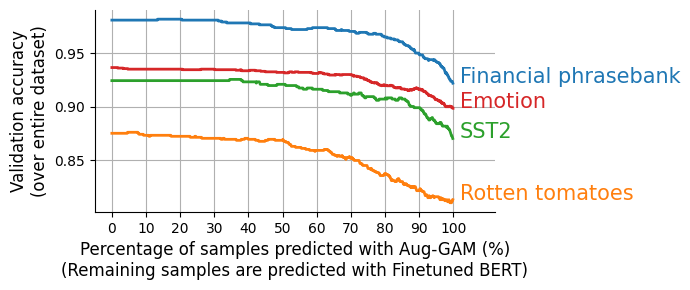

acc drops [0.007017543859649145, 0.0065666041275798115, 0.0034403669724770714, 0.0044999999999999485] 0.5381128739926494


In [5]:
dsets = out['dset']
acc_drops = []
plt.figure(figsize=(7, 3))
for i, dset in enumerate(dsets):
    num_correct_combined = out['num_correct_combined'][i]
    n = num_correct_combined.size
    plt.plot(np.arange(n) / n * 100, num_correct_combined / n, lw=2, label=analyze_helper.DSETS_RENAME_DICT[dset])
    drop = out['acc_dnn'][i] - num_correct_combined[n // 2] / n
    acc_drops.append(drop)
    plt.xlabel('Percentage of samples predicted with Aug-GAM (%)\n(Remaining samples are predicted with Finetuned BERT)', fontsize='large')
    plt.ylabel('Validation accuracy\n(over entire dataset)', fontsize='large')
plt.xticks(np.arange(0, 101, 10))
plt.grid()    
# plt.legend(bbox_to_anchor=(1.02, 0.6), fontsize='large') #, loc='upper left')
dvu.line_legend()
plt.tight_layout()
plt.savefig('acc_interpolate.pdf', bbox_inches='tight')
plt.show()
print('acc drops', acc_drops, 100 * np.array(acc_drops).mean())

In [ ]:
dsets = out['dset']
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = prop_cycle.by_key()['color']

for i, dset in enumerate(dsets):
    num_correct_cum = out['num_correct_cum'][i]
    num_correct_cum_dnn = out['num_correct_cum_dnn'][i]
    n = num_correct_cum.size
    x = np.arange(1, n + 1)
    plt.plot(x/n * 100, num_correct_cum_dnn / x, ls='--', lw=2, label='BERT ' + analyze_helper.DSETS_RENAME_DICT[dset], color=cs[i])
    plt.plot(x/n * 100, num_correct_cum / x, lw=2, label="Emb-GAM " + analyze_helper.DSETS_RENAME_DICT[dset], color=cs[i])
    plt.ylabel('Cumulative acc', fontsize='large')
    plt.xlabel('Percentage of samples %\n(sorted by uncertainty)', fontsize='large')
plt.grid()    
plt.legend(bbox_to_anchor=(1.02, 0.9), fontsize='large') #, loc='upper left')
plt.savefig('acc_calibration.pdf', bbox_inches='tight')
plt.show()